In [1]:
import pso
import dataset
import network
import numpy as np

In [2]:
# One element for every weight + 2 at end for activation functions
num_values = (
    dataset.num_features * 4 # Input layer weights
    + 4 ** 2                 # Hidden layer weights
    + 4                      # Output layer weights
    + 2                      # Activation functions
    + 2 * 4 + 1              # Bias weights for all layers
)

min_values = np.ones(num_values) * -1
max_values = np.ones(num_values) * 1

# 4 possible activation functions (0-1, 1-2, 2-3, 3-4)
min_values[-2:] = 0
max_values[-2:] = 3.99999


def fitness(coords: np.ndarray):
    net = network.network.from_list(coords, dataset.num_features)
    y_pred = net.forward_propagate(dataset.x)

    # Using loss for fitness since accuracy involved rounding which
    # means improvement will be limited to just getting probabilities
    # on the right side of 0.5
    return net.get_loss(dataset.y, y_pred)

## ANN Search

In [3]:
swarm = pso.swarm(min_values, max_values, fitness_func=fitness)
found = swarm.search(iterations=100)
model = network.network.from_list(found, dataset.num_features)

In [4]:
y_probs = model.forward_propagate(dataset.x)
y_preds = np.around(y_probs)

print(all(y_preds == 1))
print(np.mean(y_preds == dataset.y))

True
0.5555555555555556


## Tracking Particles

The following gets a list of all particle positions for each iteration of the search. Since these are multidimensional, we can only plot 1-2 diumensions at a time.

In [5]:
iterations = 500
swarm = pso.swarm(min_values, max_values, fitness_func=fitness)
swarm.set_hyperparameters(beta=0.01, gamma=0.01)
positions = swarm.track_search(iterations=iterations)

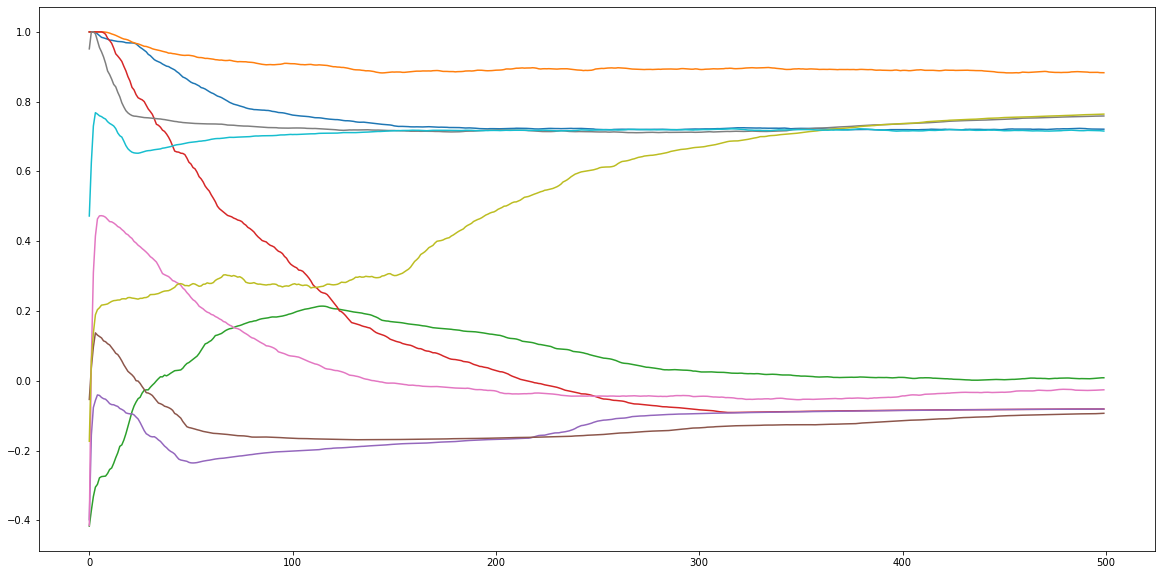

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))

timesteps = list(range(iterations))

for particle in positions:
    plt.plot(timesteps, particle[0])

plt.show()

# Simple function application

This just demonsrates that the PSO search behaves as expected (finds the minimum) on the more simple sphere function.

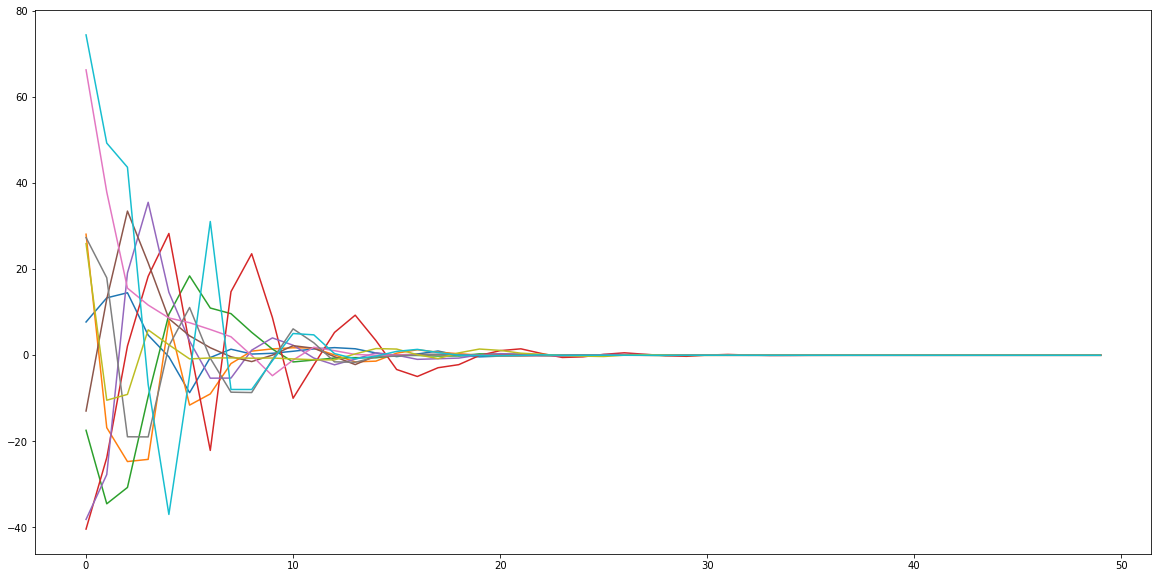

In [7]:
# use default sphere fitness function
swarm = pso.swarm(np.ones(2) * -100, np.ones(2) * 100)
positions = swarm.track_search(iterations=50)

fig = plt.figure(figsize=(20,10))

timesteps = list(range(50))

for particle in positions:
    plt.plot(timesteps, particle[1])

plt.show()

# Matthews Correlation Coefficient

In [10]:
def matts_coeff(coords: np.ndarray):
    net = network.network.from_list(coords, dataset.num_features)
    y_probs = net.forward_propagate(dataset.x)
    y_pred = np.around(y_probs).flatten()

    tp = np.sum(np.logical_and(y_pred==1, dataset.y==1))
    tn = np.sum(np.logical_and(y_pred==0, dataset.y==0))
    fp = np.sum(np.logical_and(y_pred==1, dataset.y==0))
    fn = np.sum(np.logical_and(y_pred==0, dataset.y==1))

    # avoids a divide by zero error if all instances are classified as one class
    if (tn == 0 and fn == 0) or (tp == 0 and fp == 0):
        return 0

    # Matthews Coefficient close to 1 indicates a good classifier 
    # PSO is set up to minimise fitness therefore reverse the coefficient (i.e. return the negative)
    return -(tp*tn - fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    

In [11]:
mcc_swarm = pso.swarm(min_values, max_values, fitness_func=matts_coeff)
mcc_swarm.set_hyperparameters(beta=1.2, gamma=1.9)
mcc_found = mcc_swarm.search(iterations=100)
mcc_model = network.network.from_list(mcc_found, dataset.num_features)

In [12]:
mcc_probs = mcc_model.forward_propagate(dataset.x)
mcc_preds = np.around(mcc_probs)

print(all(mcc_preds == 1))
print(np.mean(mcc_preds == dataset.y))

False
0.5068811981380288


# Investigation

Hyper-parameters investigated:
- Swarm size: in the range 10 to 100 with increments of 10 
- Search space: in the range (-1, 1) to (-100, 100) 
- Inertia weight: in the range from 0.2 to 1.2 with increments of 0.2
- Beta & Gamma values: in the range 0.5 to 2.5 (represent the results as a type of pairwise correlation matrix) 
- Epsilon: (don't have reference values for this yet)
<br>
<br>
Values largely based on: https://ieeexplore.ieee.org/document/1202255

In [49]:
import time
import pandas as pd
from typing import Iterable
from matplotlib import pyplot as plt

In [6]:
# initialise a PSO with the paramters provided 
# train an ANN using PSO
def pso_train_nn(
    swarm_size = 10,
    search_space = 1,
    inertia_weight = 1,
    beta = 1,
    gamma = 1,
    epsilon = 1,
    iterations = 100
):

    num_values = (
        dataset.num_features * 4 # Input layer weights
        + 4 ** 2                 # Hidden layer weights
        + 4                      # Output layer weights
        + 2                      # Activation functions
        + 2 * 4 + 1              # Bias weights for all layers
    )

    min_values = np.ones(num_values) * -search_space
    max_values = np.ones(num_values) * search_space

    # 4 possible activation functions (0-1, 1-2, 2-3, 3-4)
    min_values[-2:] = 0
    max_values[-2:] = 3.99999

    # setup
    swarm = pso.swarm(min_values, max_values, swarm_size=swarm_size, fitness_func=fitness)
    swarm.set_hyperparameters(alpha=inertia_weight,beta=beta, gamma=gamma, epsilon=epsilon)
    # train
    start_time = time.time()
    found = swarm.search(iterations=iterations)
    t_time = time.time() - start_time # training time
    # evaluate
    model = network.network.from_list(found, dataset.num_features)
    y_probs = model.forward_propagate(dataset.x)
    y_preds = np.around(y_probs)

    return np.mean(y_preds == dataset.y), t_time

In [39]:
def evaluate_pso_parameters(
    average_over = 10,
    swarm_size = 10,
    search_space = 1,
    inertia_weight = 1,
    beta = 1,
    gamma = 1,
    epsilon = 1,
    iterations = 100
):
    if (isinstance(swarm_size, Iterable)):
        model_count = len(swarm_size)
        iterable = swarm_size
    if (isinstance(search_space, Iterable)):
        model_count = len(search_space)
        iterable = search_space
    if (isinstance(inertia_weight, Iterable)):
        model_count = len(inertia_weight)
        iterable = inertia_weight
    if (isinstance(beta, Iterable)):
        model_count = len(beta)
        iterable = beta
    if (isinstance(gamma, Iterable)):
        model_count = len(gamma)
        iterable = gamma
    if (isinstance(epsilon, Iterable)):
        model_count = len(epsilon)
        iterable = epsilon
    if (isinstance(iterations, Iterable)):
        model_count = len(iterations)
        iterable = iterations
 
    
    accuracy = np.zeros((model_count, average_over))
    training_time = np.zeros((model_count, average_over))

    # Can only vary one hyperparameter at once
    for i in range(average_over):
        for j, itr in enumerate(iterable):
            if (isinstance(swarm_size, Iterable)):
                an, tn = pso_train_nn(itr, search_space, inertia_weight, beta, gamma, epsilon, iterations)
            
            if (isinstance(search_space, Iterable)):
                an, tn = pso_train_nn(swarm_size, itr, inertia_weight, beta, gamma, epsilon, iterations)
            
            if (isinstance(inertia_weight, Iterable)):
                an, tn = pso_train_nn(swarm_size, search_space, itr, beta, gamma, epsilon, iterations)
            
            if (isinstance(beta, Iterable)):
                an, tn = pso_train_nn(swarm_size, search_space, inertia_weight, itr, gamma, epsilon, iterations)
            
            if (isinstance(gamma, Iterable)):
                an, tn = pso_train_nn(swarm_size, search_space, inertia_weight, beta, itr, epsilon, iterations)
            
            if (isinstance(epsilon, Iterable)):
                an, tn = pso_train_nn(swarm_size, search_space, inertia_weight, beta, gamma, itr, iterations)
            
            if (isinstance(iterations, Iterable)):
                an, tn = pso_train_nn(swarm_size, search_space, inertia_weight, beta, gamma, epsilon, itr)
                # Need full time data for summary stats
            
            accuracy[j,i] = an 
            training_time[j,i] = tn

    return accuracy, training_time



In [37]:
def graph_metrics(data, labels, ylabel, xlabel='Model', dataframe=False):
    if dataframe==False:
        df = pd.DataFrame(data=data, columns=labels)
    else: 
        df=data

    boxplot = df.boxplot(figsize=(20, 6), boxprops=dict(linestyle='-', linewidth=2), showfliers=False, grid=True, rot=0, 
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             fontsize=20)
    boxplot.set_ylabel(ylabel, fontsize=20)
    boxplot.set_xlabel(xlabel, fontsize=20)


## 1. Swarm Size

In [40]:
swarm_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
sz_acc, sz_ttime = evaluate_pso_parameters(swarm_size=swarm_sizes)

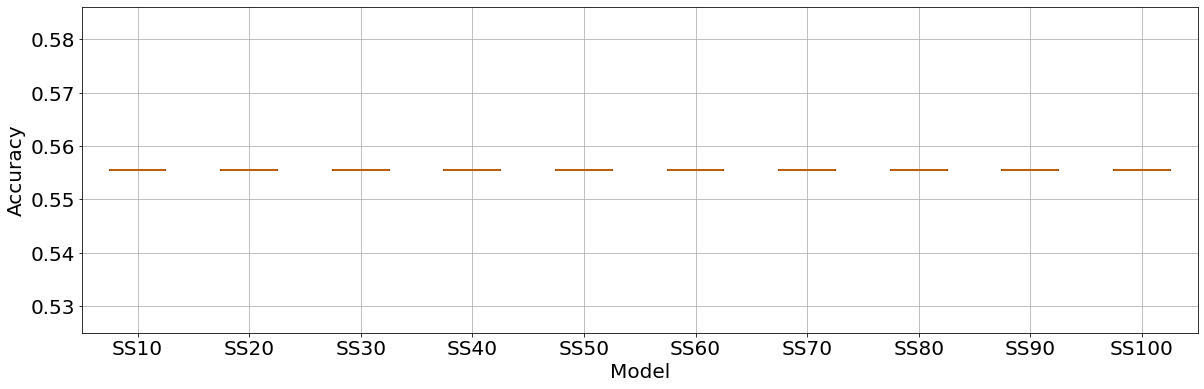

In [41]:
swarm_sizes_labels = ['SS{}'.format(i) for i in swarm_sizes]
graph_metrics(sz_acc.T, swarm_sizes_labels, ylabel='Accuracy')

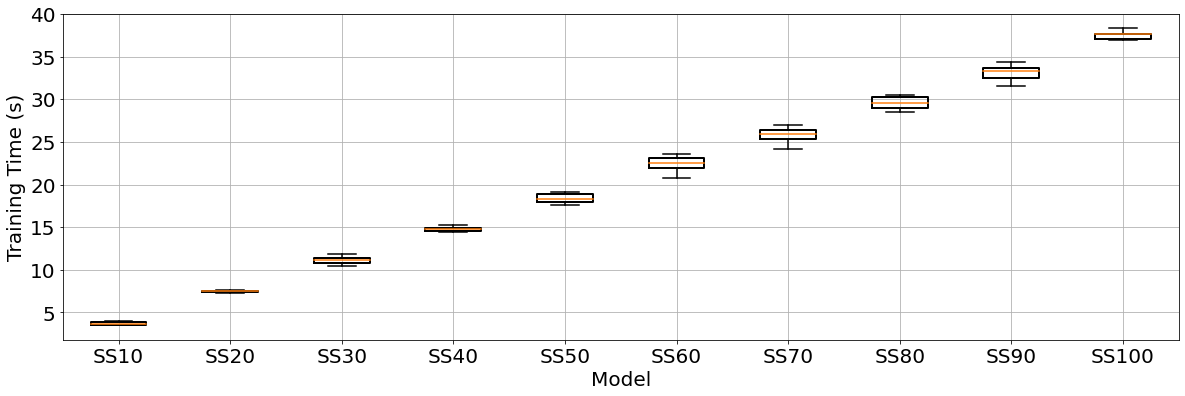

In [42]:
graph_metrics(sz_ttime.T, swarm_sizes_labels, ylabel='Training Time (s)')

## 2. Search Space

In [43]:
search_space = [1, 5, 10, 25, 50, 100]
ss_acc, ss_ttime = evaluate_pso_parameters(search_space=search_space)

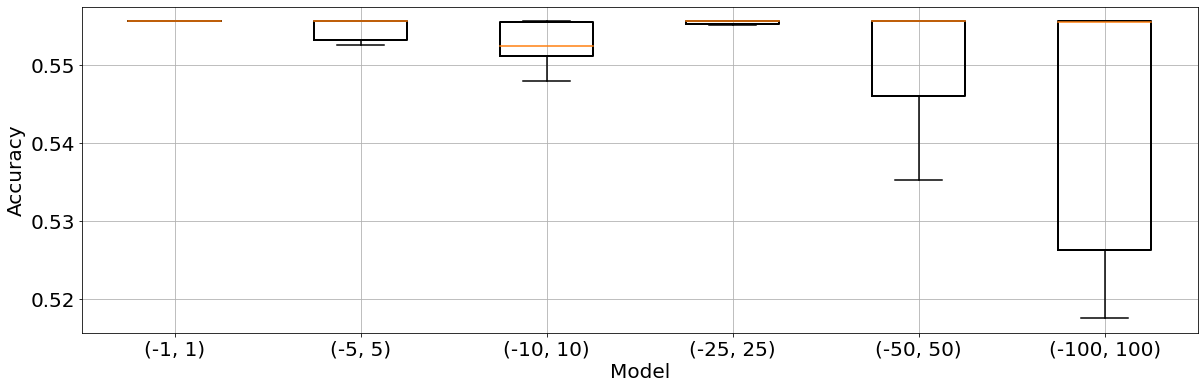

In [44]:
search_space_labels = ['(-{}, {})'.format(i, i) for i in search_space]
graph_metrics(ss_acc.T, search_space_labels, ylabel='Accuracy')

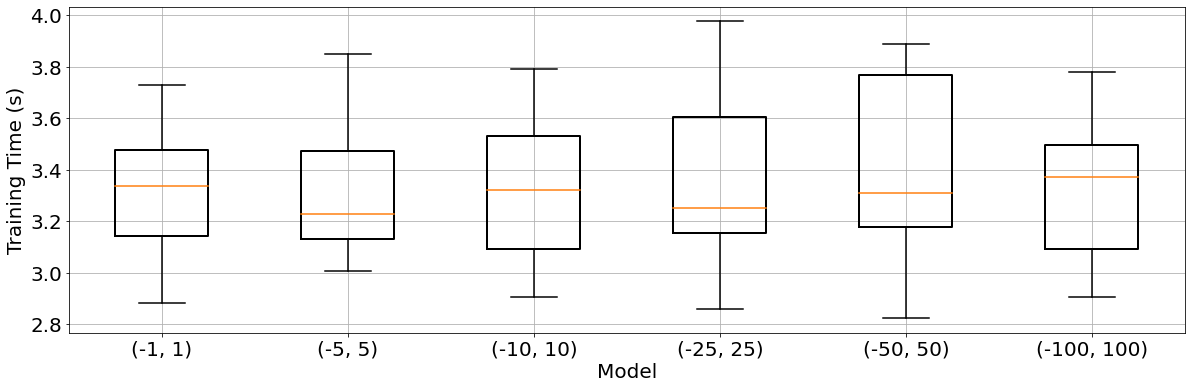

In [45]:
graph_metrics(ss_ttime.T, search_space_labels, ylabel='Training Time (s)')

## 3. Inertia Weight

In [46]:
alphas= [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
alpha_acc, alpha_ttime = evaluate_pso_parameters(inertia_weight=alphas)

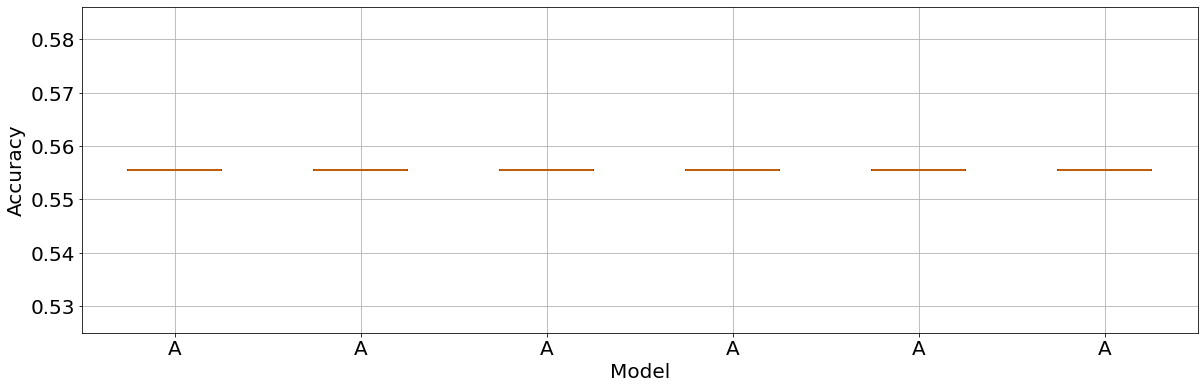

In [47]:
alphas_labels = ['A'.format(i) for i in alphas]
graph_metrics(alpha_acc.T, alphas_labels, ylabel='Accuracy')

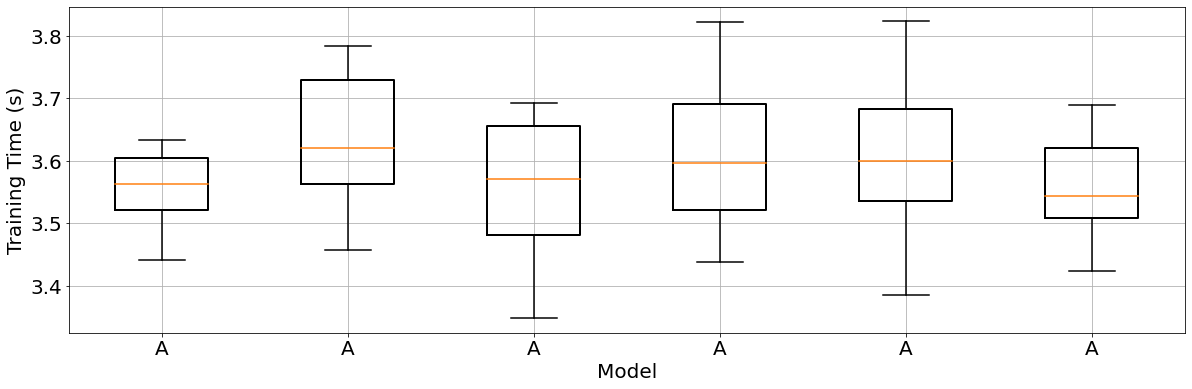

In [48]:
graph_metrics(alpha_ttime.T, alphas_labels, ylabel='Training Time (s)')

## 4. Beta & Gamma

In [92]:
beta_gamma = [0.5, 0.75, 1, 1.25, 1.5, 2, 2.5]
bg_acc, bg_ttime = np.zeros((len(beta_gamma), len(beta_gamma))), np.zeros((len(beta_gamma), len(beta_gamma)))
for i, el in enumerate(beta_gamma):
    el_acc, el_ttime = evaluate_pso_parameters(beta=el, gamma=beta_gamma)
    bg_acc[i] = np.mean(el_acc, axis=1)
    bg_ttime[i] = np.mean(el_ttime, axis=1)

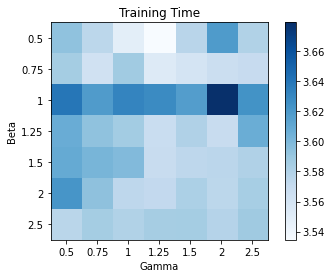

In [94]:
im = plt.imshow(bg_ttime, cmap="Blues")
plt.title('Training Time')
plt.xticks(range(len(beta_gamma)), beta_gamma)
plt.yticks(range(len(beta_gamma)), beta_gamma)
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.colorbar(im)
plt.show()

Could make a similar plot for accuracy/ loss values (would make more sense) but not much point now with all values pretty much identical.

## 5. Epsilon

In [79]:
epsilons= [0.5, 1, 1.5]
epsilons_acc, epsilons_ttime = evaluate_pso_parameters(epsilon=epsilons)

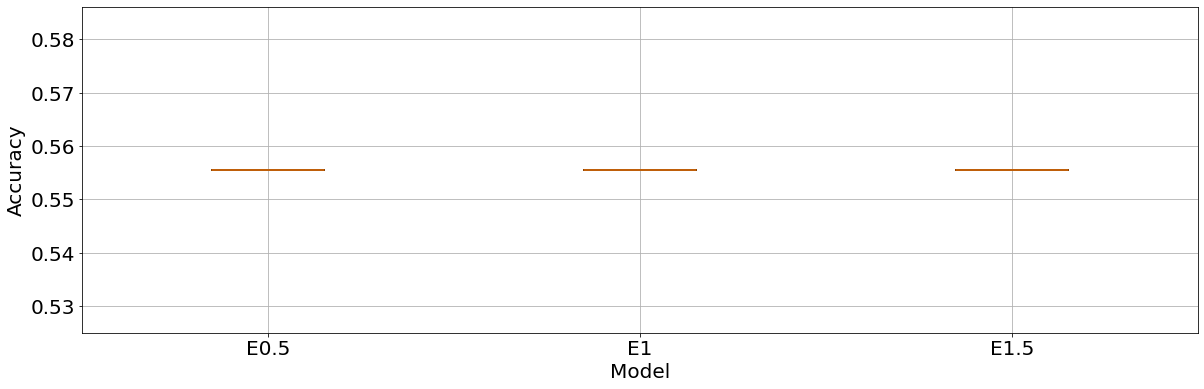

In [80]:
epsilons_labels = ['E{}'.format(i, i) for i in epsilons]
graph_metrics(epsilons_acc.T, epsilons_labels, ylabel='Accuracy')

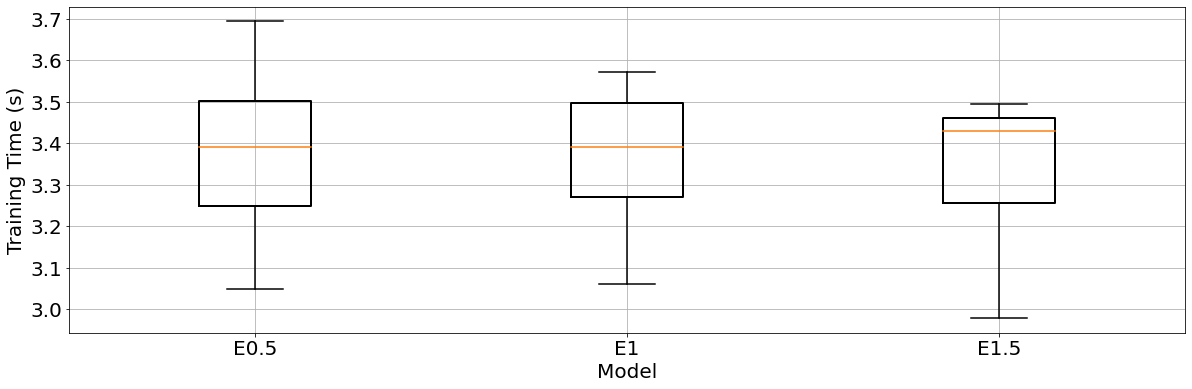

In [81]:
graph_metrics(epsilons_ttime.T, epsilons_labels, ylabel='Training Time (s)')

# PSO vs Back-propagation

The hyper-parameter investigation above should theoretically point us towards the best combinations of PSO hyper-parameters. Re-run PSO with the optimal parameters and compare training times to backpropagation (only ANNs with architecture of 2 hidden layers with 4 hidden nodes each would be relevant).

In [ ]:
backprop_tt = pd.read_csv('backprop_tt.csv')
graph_metrics(backprop_tt, dataframe=True)